# 1. Installing Packages

In [ ]:
!pip uninstall -y torch torchvision torchaudio transformers accelerate -q
!pip install torch==2.4.0 transformers==4.44.0 datasets==2.20.0 accelerate==0.33.0 scikit-learn -q

import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# 2. Imports

In [ ]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    get_linear_schedule_with_warmup,
    DataCollatorForSeq2Seq
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    PeftModel,
    prepare_model_for_kbit_training
)
from google.colab import drive
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import random
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import List, Dict, Tuple
import re
import warnings
warnings.filterwarnings('ignore')

# 3. Configuration Class

In [ ]:
class Config:
    """LoRA-optimized configuration for small dataset fine-tuning"""

    MODEL_NAME = "google/flan-t5-base"

    MAX_INPUT_LEN = 256
    MAX_TARGET_LEN = 256

    BATCH_SIZE = 4 
    GRADIENT_ACCUMULATION_STEPS = 4 
    LEARNING_RATE = 3e-4
    NUM_EPOCHS = 50
    WARMUP_RATIO = 0.1
    WEIGHT_DECAY = 0.01

    LORA_R = 16 
    LORA_ALPHA = 32
    LORA_DROPOUT = 0.1
    LORA_TARGET_MODULES = ["q", "v", "k", "o", "wi", "wo"] 

    TEMPERATURE = 0.8
    TOP_P = 0.95
    NUM_BEAMS = 6
    REPETITION_PENALTY = 1.8
    LENGTH_PENALTY = 1.1

    LR_SCHEDULER = "cosine"
    MIN_LR = 1e-6

    DRIVE_PATH = "/content/drive/MyDrive"
    MODEL_SAVE_PATH = f"{DRIVE_PATH}/pinterest-flan-t5-lora"
    DATASET_PATH = "bio.json"

    SEED = 42
    PATIENCE = 10


# 4. Utilities

In [ ]:

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def mount_drive():
    try:
        drive.mount('/content/drive')
        print("✅ Google Drive mounted successfully")
    except:
        print("⚠️ Could not mount Google Drive. Saving locally.")


# 5. Datset Class

In [ ]:
class PinterestPersonalityDataset(Dataset):
    """Dataset for Pinterest personality keywords generation"""

    def __init__(self, data, tokenizer, config, max_input_len=128, max_target_len=256):
        self.data = data
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_target_len = max_target_len
        self.config = config

    def __len__(self):
        return len(self.data)

    def _create_enhanced_input(self, item):
        """Create more informative input text"""
        name = item['name']
        culture = item.get('culture_region', '')
        role = item.get('role', '')
        period = item.get('time_period', '')
        bio = item.get('bio', '')

        input_parts = [
            f"Generate Pinterest keywords for {name}",
        ]

        context_parts = []
        if culture:
            context_parts.append(f"Culture: {culture}")
        if role:
            context_parts.append(f"Role: {role}")
        if period:
            context_parts.append(f"Period: {period}")
        if bio:
          context_parts.append(f"Bio: {bio}")

        if context_parts:
            input_parts.append(" | ".join(context_parts))

        input_parts.append("Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords")

        return " - ".join(input_parts)

    def __getitem__(self, idx):
        item = self.data[idx]

        input_text = self._create_enhanced_input(item)
        target_text = item['target_text']

        input_encoding = self.tokenizer(
            input_text,
            max_length=self.config.MAX_INPUT_LEN,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        target_encoding = self.tokenizer(
            target_text,
            max_length=self.config.MAX_TARGET_LEN,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        labels = target_encoding['input_ids'].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': input_encoding['input_ids'].squeeze(),
            'attention_mask': input_encoding['attention_mask'].squeeze(),
            'labels': labels
        }


# 6. Evaluation Metrics

In [ ]:
class PinterestEvaluator:
    """Evaluate the quality of generated Pinterest keywords"""

    def __init__(self):
        self.visual_terms = [
            'aesthetic', 'style', 'color', 'texture', 'pattern', 'design',
            'art', 'visual', 'mood', 'vibe', 'look', 'fashion', 'decor',
            'palette', 'tone', 'hue', 'shade', 'photography', 'image'
        ]

        self.pinterest_terms = [
            'board', 'pin', 'inspiration', 'diy', 'craft', 'vintage',
            'rustic', 'minimalist', 'boho', 'chic', 'glam', 'cozy',
            'aesthetic', 'mood', 'vibe', 'style', 'ideas', 'inspo'
        ]

    def calculate_keyword_diversity(self, keywords_list: List[str]) -> float:
        """Calculate diversity score for generated keywords"""

        all_keywords = []
        for keywords in keywords_list:
            all_keywords.extend([k.strip() for k in keywords.split(',')])

        unique_keywords = set(all_keywords)
        diversity_score = len(unique_keywords) / len(all_keywords) if all_keywords else 0

        return diversity_score

    def evaluate_quality(self, generated_text: str) -> Dict[str, float]:
        """Evaluate the Pinterest-specific quality of generated keywords"""

        keywords = [k.strip().lower() for k in generated_text.split(',')]

        # Visual score
        visual_score = sum(1 for keyword in keywords
                          for term in self.visual_terms if term in keyword) / len(keywords)

        # Pinterest score
        pinterest_score = sum(1 for keyword in keywords
                             for term in self.pinterest_terms if term in keyword) / len(keywords)

        # Length and diversity
        avg_keyword_length = np.mean([len(k) for k in keywords])
        keyword_diversity = len(set(keywords)) / len(keywords)

        return {
            'visual_score': visual_score,
            'pinterest_score': pinterest_score,
            'avg_keyword_length': avg_keyword_length,
            'keyword_diversity': keyword_diversity,
            'total_keywords': len(keywords)
        }

# 7. Training Class

In [ ]:
class PinterestLoRATrainer:
    """LoRA training class for Pinterest keyword generation"""

    def __init__(self, config: Config):
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        # Initialize components
        self.evaluator = PinterestEvaluator()

        # Load base model and tokenizer
        print(f"Loading base model: {config.MODEL_NAME}")
        self.tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)
        self.base_model = AutoModelForSeq2SeqLM.from_pretrained(
            config.MODEL_NAME,
            torch_dtype=torch.float32
        ).to(self.device)

        lora_config = LoraConfig(
            r=config.LORA_R,
            lora_alpha=config.LORA_ALPHA,
            target_modules=config.LORA_TARGET_MODULES,
            lora_dropout=config.LORA_DROPOUT,
            bias="none",
            task_type=TaskType.SEQ_2_SEQ_LM,
        )

        self.model = get_peft_model(self.base_model, lora_config)

        self.model.print_trainable_parameters()

        print(f"✅ LoRA model loaded with {self.count_parameters():,} trainable parameters")

    def count_parameters(self):
        """Count trainable parameters"""
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def prepare_data(self, data_path: str) -> Tuple[List[Dict], List[Dict]]:
        """Load and prepare the dataset"""

        print("\n📂 Loading dataset...")
        with open(data_path, 'r') as f:
            data = json.load(f)

        print(f"Loaded {len(data)} personalities")

        cleaned_data = self._validate_data(data)

        train_data, val_data = train_test_split(
            cleaned_data,
            test_size=0.15,
            random_state=self.config.SEED
        )

        print(f"Training samples: {len(train_data)}")
        print(f"Validation samples: {len(val_data)}")

        return train_data, val_data

    def _validate_data(self, data: List[Dict]) -> List[Dict]:
        """Validate and clean the dataset"""

        cleaned_data = []
        required_fields = ['name', 'target_text']

        for item in data:
            if all(field in item for field in required_fields):
                cleaned_item = {}
                for key, value in item.items():
                    if isinstance(value, str):
                        cleaned_item[key] = value.strip()
                    else:
                        cleaned_item[key] = value

                keywords = [k.strip() for k in cleaned_item['target_text'].split(',') if k.strip()]
                cleaned_item['target_text'] = ', '.join(keywords)

                cleaned_item.setdefault('culture_region', '')
                cleaned_item.setdefault('role', '')
                cleaned_item.setdefault('time_period', '')

                cleaned_data.append(cleaned_item)

        return cleaned_data

    def train(self, train_data: List[Dict], val_data: List[Dict]):
        """Main LoRA training loop"""

        train_dataset = PinterestPersonalityDataset(train_data, self.tokenizer, self.config)
        val_dataset = PinterestPersonalityDataset(val_data, self.tokenizer, self.config)

        data_collator = DataCollatorForSeq2Seq(
            self.tokenizer,
            model=self.model,
            label_pad_token_id=-100
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=self.config.BATCH_SIZE,
            shuffle=True,
            collate_fn=data_collator,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=self.config.BATCH_SIZE,
            collate_fn=data_collator,
            pin_memory=True
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.config.LEARNING_RATE,
            weight_decay=self.config.WEIGHT_DECAY,
            eps=1e-8,
            betas=(0.9, 0.999)
        )

        total_steps = len(train_loader) * self.config.NUM_EPOCHS // self.config.GRADIENT_ACCUMULATION_STEPS
        warmup_steps = int(total_steps * self.config.WARMUP_RATIO)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

        history = defaultdict(list)
        best_val_loss = float('inf')
        patience_counter = 0

        print(f"\n🎯 Starting LoRA training...")
        print(f"Effective batch size: {self.config.BATCH_SIZE * self.config.GRADIENT_ACCUMULATION_STEPS}")
        print(f"Learning rate: {self.config.LEARNING_RATE}")
        print(f"Total training steps: {total_steps}")
        print(f"Warmup steps: {warmup_steps}")

        for epoch in range(self.config.NUM_EPOCHS):
            print(f"\n{'='*60}")
            print(f"📍 Epoch {epoch + 1}/{self.config.NUM_EPOCHS}")
            print(f"{'='*60}")

            train_loss = self._train_epoch(train_loader, optimizer, scheduler)
            history['train_loss'].append(train_loss)

            val_loss, val_examples, diversity_score = self._validate_epoch(val_loader)
            history['val_loss'].append(val_loss)
            history['diversity'].append(diversity_score)

            # Print metrics
            print(f"\n📊 Metrics:")
            print(f"Training Loss: {train_loss:.4f}")
            print(f"Validation Loss: {val_loss:.4f}")
            print(f"Keyword Diversity: {diversity_score:.4f}")
            print(f"Learning Rate: {scheduler.get_last_lr()[0]:.2e}")

            self._show_examples(val_examples)

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self._save_model("best")
                patience_counter = 0
                print(f"🎉 New best model saved! Val Loss: {val_loss:.4f}")
            else:
                patience_counter += 1

            # Early stopping
            if patience_counter >= self.config.PATIENCE:
                print(f"\n⚠️ Early stopping at epoch {epoch + 1}")
                break

        self._save_model("final")

        self._plot_history(history)

        return history

    def _train_epoch(self, train_loader, optimizer, scheduler):
        """Training epoch for LoRA"""

        self.model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc="Training")

        optimizer.zero_grad()

        for step, batch in enumerate(progress_bar):
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss / self.config.GRADIENT_ACCUMULATION_STEPS
            total_loss += loss.item() * self.config.GRADIENT_ACCUMULATION_STEPS

            loss.backward()

            if (step + 1) % self.config.GRADIENT_ACCUMULATION_STEPS == 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            progress_bar.set_postfix({
                'loss': loss.item() * self.config.GRADIENT_ACCUMULATION_STEPS,
                'lr': scheduler.get_last_lr()[0]
            })

        return total_loss / len(train_loader)

    def _validate_epoch(self, val_loader):
        """Validation epoch"""

        self.model.eval()
        total_loss = 0
        all_generated = []
        val_examples = []

        total_batches = len(val_loader)
        example_batch_indices = random.sample(range(total_batches), min(3, total_batches))

        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(val_loader, desc="Validation")):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_loss += outputs.loss.item()

                if batch_idx in example_batch_indices:
                    batch_size = input_ids.size(0)
                    sample_indices = random.sample(range(batch_size), min(2, batch_size))

                    for i in sample_indices:
                        generated = self.model.generate(
                            input_ids=input_ids[i:i+1],
                            attention_mask=attention_mask[i:i+1],
                            max_length=self.config.MAX_TARGET_LEN,
                            num_beams=self.config.NUM_BEAMS,
                            temperature=self.config.TEMPERATURE,
                            do_sample=True,
                            top_p=self.config.TOP_P,
                            repetition_penalty=self.config.REPETITION_PENALTY,
                            length_penalty=self.config.LENGTH_PENALTY,
                            early_stopping=True,
                            pad_token_id=self.tokenizer.pad_token_id
                        )

                        input_text = self.tokenizer.decode(input_ids[i], skip_special_tokens=True)
                        generated_text = self.tokenizer.decode(generated[0], skip_special_tokens=True)
                        actual_text = self.tokenizer.decode(
                            labels[i][labels[i] != -100],
                            skip_special_tokens=True
                        )

                        val_examples.append({
                            'input': input_text,
                            'generated': generated_text,
                            'actual': actual_text
                        })

                        all_generated.append(generated_text)

        avg_loss = total_loss / len(val_loader)
        diversity_score = self.evaluator.calculate_keyword_diversity(all_generated)

        return avg_loss, val_examples, diversity_score

    def _show_examples(self, examples):
        """Display validation examples"""

        print(f"\n📝 Validation Examples ({len(examples)} total):")
        print("=" * 80)

        for i, ex in enumerate(examples, 1):
            input_parts = ex['input'].split(' - ')
            personality_info = input_parts[0] if input_parts else "Unknown"

            print(f"\n🎭 Example {i}: {personality_info}")
            print(f"📥 Input: {ex['input'][:100]}{'...' if len(ex['input']) > 100 else ''}")
            print(f"🎯 Generated: {ex['generated']}")
            print(f"✅ Expected: {ex['actual']}")

            quality = self.evaluator.evaluate_quality(ex['generated'])
            print(f"📊 Quality - Visual: {quality['visual_score']:.2f}, "
                  f"Pinterest: {quality['pinterest_score']:.2f}, "
                  f"Diversity: {quality['keyword_diversity']:.2f}")
            print("-" * 80)

    def _save_model(self, suffix):
        """Save LoRA model"""

        save_path = f"{self.config.MODEL_SAVE_PATH}-{suffix}"
        os.makedirs(save_path, exist_ok=True)

        self.model.save_pretrained(save_path)
        self.tokenizer.save_pretrained(save_path)

        print(f"💾 LoRA model saved to: {save_path}")

    def _plot_history(self, history):
        """Plot training history"""

        plt.figure(figsize=(15, 5))

        # Loss plot
        plt.subplot(1, 3, 1)
        plt.plot(history['train_loss'], label='Train Loss', marker='o')
        plt.plot(history['val_loss'], label='Val Loss', marker='s')
        plt.title('Training Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Diversity plot
        plt.subplot(1, 3, 2)
        plt.plot(history['diversity'], label='Keyword Diversity', marker='d', color='green')
        plt.title('Generation Diversity')
        plt.xlabel('Epoch')
        plt.ylabel('Diversity Score')
        plt.legend()
        plt.grid(True)

        # Combined metrics
        plt.subplot(1, 3, 3)
        epochs = range(1, len(history['train_loss']) + 1)
        plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
        plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
        plt.plot(epochs, history['diversity'], 'g--', label='Diversity')
        plt.title('All Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(f'{self.config.DRIVE_PATH}/pinterest_lora_training_history.png', dpi=150)
        plt.show()

# 8. Inference Class

In [ ]:
class PinterestLoRAGenerator:
    """Generate Pinterest keywords using LoRA fine-tuned model"""

    def __init__(self, model_path: str, base_model_name: str = "google/flan-t5-base"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        print(f"Loading LoRA model from {model_path}...")

        self.tokenizer = AutoTokenizer.from_pretrained(model_path)

        base_model = AutoModelForSeq2SeqLM.from_pretrained(
            base_model_name,
            torch_dtype=torch.float32
        )

        self.model = PeftModel.from_pretrained(base_model, model_path).to(self.device)
        self.model.eval()

        self.evaluator = PinterestEvaluator()
        print("✅ LoRA model loaded successfully!")

    def generate(
        self,
        personality_name: str,
        role: str = "",
        culture_region: str = "",
        time_period: str = "",
        bio: str = "",
        num_variations: int = 1
    ) -> Dict:
        """Generate Pinterest keywords using LoRA model"""

        input_parts = [f"Generate Pinterest keywords for {personality_name}"]
        context_parts = []

        if culture_region:
            context_parts.append(f"Culture: {culture_region}")
        if role:
            context_parts.append(f"Role: {role}")
        if time_period:
            context_parts.append(f"Period: {time_period}")
        if bio:
            context_parts.append(f"Bio: {bio}")

        if context_parts:
            input_parts.append(" | ".join(context_parts))

        input_parts.append("Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords")

        prompt = " - ".join(input_parts)

        inputs = self.tokenizer(
            prompt,
            max_length=256,
            return_tensors='pt',
            truncation=True
        ).to(self.device)

        results = []

        for _ in range(num_variations):
            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_length=300,
                    num_beams=8,
                    temperature=0.9,
                    do_sample=True,
                    top_p=0.95,
                    repetition_penalty=2.0,
                    length_penalty=1.2,
                    early_stopping=True,
                    no_repeat_ngram_size=2,
                )

            generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            quality = self.evaluator.evaluate_quality(generated_text)

            results.append({
                'keywords': generated_text,
                'quality': quality
            })

        return {
            'personality': personality_name,
            'role': role,
            'culture_region': culture_region,
            'time_period': time_period,
            'variations': results
        }

# 9. Main Function

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully
Using device: cuda
Loading base model: google/flan-t5-base
trainable params: 4,620,288 || all params: 252,198,144 || trainable%: 1.8320
✅ LoRA model loaded with 4,620,288 trainable parameters

📂 Loading dataset...
Loaded 101 personalities
Training samples: 85
Validation samples: 16

🎯 Starting LoRA training...
Effective batch size: 16
Learning rate: 0.0003
Total training steps: 275
Warmup steps: 27

📍 Epoch 1/50


Validation: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]



📊 Metrics:
Training Loss: 4.2452
Validation Loss: 3.8475
Keyword Diversity: 1.0000
Learning Rate: 5.56e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Zhou Fang
📥 Input: Generate Pinterest keywords for Zhou Fang - Culture: Chinese | Role: Painter | Period: Tang Dynasty ...
🎯 Generated: Zhou Fang -lrb- painter -rrb-
✅ Expected: chinese aristocratic women, floral robes, gentle expressionism, ink and silk beauty, elegant femininity, indoor scenes, Tang lifestyle art
📊 Quality - Visual: 0.00, Pinterest: 0.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: Captain America, Super Soldier, World War II, Modern
✅ Expected: vintage war posters, star shield motif, patriotic tones, 1940s fashion, military aesthetics, red-white

Validation: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]



📊 Metrics:
Training Loss: 4.1425
Validation Loss: 3.7974
Keyword Diversity: 1.0000
Learning Rate: 1.11e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: Captain America, Super Soldier, World War II and Modern
✅ Expected: vintage war posters, star shield motif, patriotic tones, 1940s fashion, military aesthetics, red-white-blue color scheme, captain america shield
📊 Quality - Visual: 0.00, Pinterest: 0.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Mahatma Gandhi
📥 Input: Generate Pinterest keywords for Mahatma Gandhi - Culture: Indian | Role: Freedom Leader | Period: 20...
🎯 Generated: Mahatma Gandhi, Indian | Role: Freedom Leader | Period: 20th Century | Bio
✅ Expected: handspun khadi cloth, round spectacles, spi

Validation: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it]



📊 Metrics:
Training Loss: 4.1135
Validation Loss: 3.7071
Keyword Diversity: 0.9500
Learning Rate: 1.67e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Mahatma Gandhi
📥 Input: Generate Pinterest keywords for Mahatma Gandhi - Culture: Indian | Role: Freedom Leader | Period: 20...
🎯 Generated: Mahatma Gandhi was a leader of India’s nonviolent independence movement against British rule. He pioneered civil disobedience and satyagraha, emphasizing self-reliance, khadi cloth, and peaceful protest as tools of resistance
✅ Expected: handspun khadi cloth, round spectacles, spinning wheels, british india aesthetics, Hinduism, nonviolent resistance
📊 Quality - Visual: 0.00, Pinterest: 0.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 G

Validation: 100%|██████████| 4/4 [00:08<00:00,  2.16s/it]



📊 Metrics:
Training Loss: 4.0064
Validation Loss: 3.5830
Keyword Diversity: 1.0000
Learning Rate: 2.22e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Persephone
📥 Input: Generate Pinterest keywords for Persephone - Culture: Greek | Role: Mythology | Period: Ancient | Bi...
🎯 Generated: Persephone is the Greek goddess of spring and queen of the underworld.
✅ Expected: persephone core, pomegranate imagery, floral crown, underworld duality, soft marble beauty, spring flowers, goddess of seasons, mythic femininity, life and death aesthetic
📊 Quality - Visual: 0.00, Pinterest: 0.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Hattori Hanz
📥 Input: Generate Pinterest keywords for Hattori Hanz - Culture: Japanese | Role: Warrior | Period: Sengoku P...
🎯 Generated: Hattori Hanz was a legendary ninja and samurai who served Tokugawa Ieyasu.
✅ Expected: sengoku 

Validation: 100%|██████████| 4/4 [00:10<00:00,  2.52s/it]



📊 Metrics:
Training Loss: 3.8611
Validation Loss: 3.3892
Keyword Diversity: 1.0000
Learning Rate: 2.78e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: Bhagat Singh was a revolutionary socialist who became a symbol of youth rebellion against British colonial rule.
✅ Expected: British jail cell shadows, indian architecture, paper bombs, turbaned defiance, ink-and-blood manifestos, british colonial resistance, british india aesthetics, british india
📊 Quality - Visual: 0.00, Pinterest: 0.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Zhou Fang
📥 Input: Generate Pinterest keywords for Zhou Fang - Culture: Chinese | Role: Painter | Period: Tang Dynasty ...
🎯 Generated: Zhou Fang was a painter in the mid to late Tang Dyn

Validation: 100%|██████████| 4/4 [00:06<00:00,  1.69s/it]



📊 Metrics:
Training Loss: 3.6508
Validation Loss: 3.1671
Keyword Diversity: 0.9524
Learning Rate: 2.96e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: british colonial rule, youth rebellion, freedom fighters
✅ Expected: British jail cell shadows, indian architecture, paper bombs, turbaned defiance, ink-and-blood manifestos, british colonial resistance, british india aesthetics, british india
📊 Quality - Visual: 0.00, Pinterest: 0.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Mahatma Gandhi
📥 Input: Generate Pinterest keywords for Mahatma Gandhi - Culture: Indian | Role: Freedom Leader | Period: 20...
🎯 Generated: Mahatma Gandhi, satyagraha, khadi cloth, freedom movement
✅ Expected: handspun khadi cloth, round spec

Validation: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it]



📊 Metrics:
Training Loss: 3.4194
Validation Loss: 3.0436
Keyword Diversity: 0.7667
Learning Rate: 2.90e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: bhagat singh, freedom fighters, youth rebellion, revolutionary movement
✅ Expected: British jail cell shadows, indian architecture, paper bombs, turbaned defiance, ink-and-blood manifestos, british colonial resistance, british india aesthetics, british india
📊 Quality - Visual: 0.00, Pinterest: 0.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: avengers, superheroes, supersoldiers
✅ Expected: vintage war posters, star shield moti

Validation: 100%|██████████| 4/4 [00:08<00:00,  2.04s/it]



📊 Metrics:
Training Loss: 3.3447
Validation Loss: 2.9484
Keyword Diversity: 0.8929
Learning Rate: 2.84e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Hattori Hanz
📥 Input: Generate Pinterest keywords for Hattori Hanz - Culture: Japanese | Role: Warrior | Period: Sengoku P...
🎯 Generated: japanese samurai, tokugawa samurai, ninja samurai, shizuoka samurai
✅ Expected: sengoku period art, japanese ninja aesthetics, japanese architecture art, black night armor, moonlit infiltration, Tokugawa Ieyasu, japanese ninja weapons aesthetic, samurai aesthetic, shadowy espionage, traditional ninja sandals, japanese ink wash aesthetic
📊 Quality - Visual: 0.00, Pinterest: 0.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Ramses II
📥 Input: Generate Pinterest keywords for Ramses II - Culture: Egyptian | Role: Royalty | Period: 19th Dynasty...
🎯 Generated: pharaohs of 

Validation: 100%|██████████| 4/4 [00:09<00:00,  2.48s/it]



📊 Metrics:
Training Loss: 3.1786
Validation Loss: 2.8771
Keyword Diversity: 0.8485
Learning Rate: 2.78e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Zhou Fang
📥 Input: Generate Pinterest keywords for Zhou Fang - Culture: Chinese | Role: Painter | Period: Tang Dynasty ...
🎯 Generated: tang dynasty aesthetic, aristocratic beauty, aristocratic art, aristocratic women, aristocratic paintings, aristocratic style, aristocratic painting
✅ Expected: chinese aristocratic women, floral robes, gentle expressionism, ink and silk beauty, elegant femininity, indoor scenes, Tang lifestyle art
📊 Quality - Visual: 0.43, Pinterest: 0.29, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: avengers aesthetic, supersoldier aesthetic, Aven

Validation: 100%|██████████| 4/4 [00:12<00:00,  3.03s/it]



📊 Metrics:
Training Loss: 3.0828
Validation Loss: 2.8290
Keyword Diversity: 0.8529
Learning Rate: 2.72e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Hatshepsut
📥 Input: Generate Pinterest keywords for Hatshepsut - Culture: Egyptian | Role: Royalty | Period: 18th Dynast...
🎯 Generated: egyptian kings, egyptian palaces, egyptian temples, egyptian architecture, egyptian art, egyptian royalty, egyptian architecture
✅ Expected: 18th dynasty egypt aesthetic, egyptian queen garb, mortuary temple, sandstone ramps, gold-and-white aesthetic, egyptian trade expedition murals, egyptian queen, ancient egypt aesthetic, stone sphinx path, regal hieroglyphs
📊 Quality - Visual: 0.14, Pinterest: 0.00, Diversity: 0.86
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Ramses II
📥 Input: Generate Pinterest keywords for Ramses II - Culture: Egyptian | Role: Royalty | Period: 19th Dynasty...
🎯 

Validation: 100%|██████████| 4/4 [00:12<00:00,  3.06s/it]



📊 Metrics:
Training Loss: 3.0364
Validation Loss: 2.8022
Keyword Diversity: 0.8000
Learning Rate: 2.66e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Zhou Fang
📥 Input: Generate Pinterest keywords for Zhou Fang - Culture: Chinese | Role: Painter | Period: Tang Dynasty ...
🎯 Generated: tang dynasty aesthetic, aristocratic beauty, aristocratic art, aristocratic women, aristocratic painting, aristocratic portraits, aristocratic style
✅ Expected: chinese aristocratic women, floral robes, gentle expressionism, ink and silk beauty, elegant femininity, indoor scenes, Tang lifestyle art
📊 Quality - Visual: 0.43, Pinterest: 0.29, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: freedom fighters, british colonial style, Indian re

Validation: 100%|██████████| 4/4 [00:10<00:00,  2.61s/it]



📊 Metrics:
Training Loss: 2.9737
Validation Loss: 2.7799
Keyword Diversity: 0.9730
Learning Rate: 2.60e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: freedom fighters, british colonial rule, Indian revolution aesthetic, revolutionary protests, british colonial history, liberation movement aesthetic
✅ Expected: British jail cell shadows, indian architecture, paper bombs, turbaned defiance, ink-and-blood manifestos, british colonial resistance, british india aesthetics, british india
📊 Quality - Visual: 0.33, Pinterest: 0.33, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Mahatma Gandhi
📥 Input: Generate Pinterest keywords for Mahatma Gandhi - Culture: Indian | Role: Freedom Leader | Period: 20...
🎯 Generated: satyagrah

Validation: 100%|██████████| 4/4 [00:14<00:00,  3.51s/it]



📊 Metrics:
Training Loss: 2.9830
Validation Loss: 2.7637
Keyword Diversity: 0.7568
Learning Rate: 2.54e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: avengers aesthetic, wartime heroes, ice sculptures, avengers uniforms, Marvel comics aesthetic, avengers armor, avengers aesthetic
✅ Expected: vintage war posters, star shield motif, patriotic tones, 1940s fashion, military aesthetics, red-white-blue color scheme, captain america shield
📊 Quality - Visual: 0.57, Pinterest: 0.43, Diversity: 0.86
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Mahatma Gandhi
📥 Input: Generate Pinterest keywords for Mahatma Gandhi - Culture: Indian | Role: Freedom Leader | Period: 20...
🎯 Generated: satyagraha, Indian independence movement, khadi cloth, 

Validation: 100%|██████████| 4/4 [00:10<00:00,  2.73s/it]



📊 Metrics:
Training Loss: 2.9193
Validation Loss: 2.7460
Keyword Diversity: 0.8378
Learning Rate: 2.48e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Mahatma Gandhi
📥 Input: Generate Pinterest keywords for Mahatma Gandhi - Culture: Indian | Role: Freedom Leader | Period: 20...
🎯 Generated: satyagraha, khadi cloth, liberation movement, Indian independence movement, Gandhi aesthetic
✅ Expected: handspun khadi cloth, round spectacles, spinning wheels, british india aesthetics, Hinduism, nonviolent resistance
📊 Quality - Visual: 0.20, Pinterest: 0.20, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Zhou Fang
📥 Input: Generate Pinterest keywords for Zhou Fang - Culture: Chinese | Role: Painter | Period: Tang Dynasty ...
🎯 Generated: tang dynasty aesthetic, aristocratic beauty, aristocratic art, aristocratic paintings, chinese art aesthetic, aristocratic women,

Validation: 100%|██████████| 4/4 [00:09<00:00,  2.46s/it]



📊 Metrics:
Training Loss: 2.8552
Validation Loss: 2.7279
Keyword Diversity: 0.8889
Learning Rate: 2.42e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: british colonial rule, youth rebellion, revolutionary activism, revolutionaries in India, freedom fighters, Indian revolution aesthetic
✅ Expected: British jail cell shadows, indian architecture, paper bombs, turbaned defiance, ink-and-blood manifestos, british colonial resistance, british india aesthetics, british india
📊 Quality - Visual: 0.17, Pinterest: 0.17, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Mahatma Gandhi
📥 Input: Generate Pinterest keywords for Mahatma Gandhi - Culture: Indian | Role: Freedom Leader | Period: 20...
🎯 Generated: khadi cloth, liberation

Validation: 100%|██████████| 4/4 [00:11<00:00,  2.99s/it]



📊 Metrics:
Training Loss: 2.8520
Validation Loss: 2.7064
Keyword Diversity: 0.8462
Learning Rate: 2.36e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: british colonial rule, youthful rebellion, Indian revolution aesthetics, freedom fighters, liberation movement aesthetics
✅ Expected: British jail cell shadows, indian architecture, paper bombs, turbaned defiance, ink-and-blood manifestos, british colonial resistance, british india aesthetics, british india
📊 Quality - Visual: 0.40, Pinterest: 0.40, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Mahatma Gandhi
📥 Input: Generate Pinterest keywords for Mahatma Gandhi - Culture: Indian | Role: Freedom Leader | Period: 20...
🎯 Generated: satyagraha, khadi cloth, Indian indep

Validation: 100%|██████████| 4/4 [00:10<00:00,  2.73s/it]



📊 Metrics:
Training Loss: 2.7896
Validation Loss: 2.6847
Keyword Diversity: 0.7778
Learning Rate: 2.30e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Zhou Fang
📥 Input: Generate Pinterest keywords for Zhou Fang - Culture: Chinese | Role: Painter | Period: Tang Dynasty ...
🎯 Generated: tang dynasty aesthetic, aristocratic beauty, chinese art aesthetic, chinese art aesthetic, chinese art aesthetic, chinese art aesthetic
✅ Expected: chinese aristocratic women, floral robes, gentle expressionism, ink and silk beauty, elegant femininity, indoor scenes, Tang lifestyle art
📊 Quality - Visual: 1.50, Pinterest: 0.83, Diversity: 0.50
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Mahatma Gandhi
📥 Input: Generate Pinterest keywords for Mahatma Gandhi - Culture: Indian | Role: Freedom Leader | Period: 20...
🎯 Generated: satyagraha, khadi cloth, liberation movement aesthetic, Indian

Validation: 100%|██████████| 4/4 [00:10<00:00,  2.72s/it]



📊 Metrics:
Training Loss: 2.7173
Validation Loss: 2.6723
Keyword Diversity: 0.9412
Learning Rate: 2.24e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: avengers aesthetic, ice sculptures, superhero shields, wartime combat uniforms, ice-cold heroes, avengers armor
✅ Expected: vintage war posters, star shield motif, patriotic tones, 1940s fashion, military aesthetics, red-white-blue color scheme, captain america shield
📊 Quality - Visual: 0.33, Pinterest: 0.17, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Zhou Fang
📥 Input: Generate Pinterest keywords for Zhou Fang - Culture: Chinese | Role: Painter | Period: Tang Dynasty ...
🎯 Generated: tang dynasty aesthetic, aristocratic women, chinese art aesthetic, chinese pain

Validation: 100%|██████████| 4/4 [00:13<00:00,  3.49s/it]



📊 Metrics:
Training Loss: 2.7714
Validation Loss: 2.6663
Keyword Diversity: 0.8205
Learning Rate: 2.18e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: avengers aesthetic, snowy battlefields, ice-cold superheroes, wartime uniforms, ice storms, Captain America aesthetic, avengers nostalgia
✅ Expected: vintage war posters, star shield motif, patriotic tones, 1940s fashion, military aesthetics, red-white-blue color scheme, captain america shield
📊 Quality - Visual: 0.43, Pinterest: 0.29, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: british colonial rule, youth rebellion aesthetics,

Validation: 100%|██████████| 4/4 [00:11<00:00,  2.94s/it]



📊 Metrics:
Training Loss: 2.7102
Validation Loss: 2.6477
Keyword Diversity: 0.9189
Learning Rate: 2.12e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Hattori Hanz
📥 Input: Generate Pinterest keywords for Hattori Hanz - Culture: Japanese | Role: Warrior | Period: Sengoku P...
🎯 Generated: japanese samurai aesthetic, sengoku period art, japanese samurai aesthetic, japanese ninja aesthetic, japanese samurai aesthetic
✅ Expected: sengoku period art, japanese ninja aesthetics, japanese architecture art, black night armor, moonlit infiltration, Tokugawa Ieyasu, japanese ninja weapons aesthetic, samurai aesthetic, shadowy espionage, traditional ninja sandals, japanese ink wash aesthetic
📊 Quality - Visual: 1.00, Pinterest: 0.80, Diversity: 0.60
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Persephone
📥 Input: Generate Pinterest keywords for Persephone - Culture: Greek | Role:

Validation: 100%|██████████| 4/4 [00:13<00:00,  3.30s/it]



📊 Metrics:
Training Loss: 2.7117
Validation Loss: 2.6365
Keyword Diversity: 0.8095
Learning Rate: 2.06e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Hatshepsut
📥 Input: Generate Pinterest keywords for Hatshepsut - Culture: Egyptian | Role: Royalty | Period: 18th Dynast...
🎯 Generated: egyptian kings, egyptian palaces, egyptian royalty, egyptian trade expeditions, egyptian dynasty aesthetics, egyptian architecture, egyptian temples
✅ Expected: 18th dynasty egypt aesthetic, egyptian queen garb, mortuary temple, sandstone ramps, gold-and-white aesthetic, egyptian trade expedition murals, egyptian queen, ancient egypt aesthetic, stone sphinx path, regal hieroglyphs
📊 Quality - Visual: 0.14, Pinterest: 0.14, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Ramses II
📥 Input: Generate Pinterest keywords for Ramses II - Culture: Egyptian | Role: Royalty | Period

Validation: 100%|██████████| 4/4 [00:11<00:00,  2.98s/it]



📊 Metrics:
Training Loss: 2.6441
Validation Loss: 2.6310
Keyword Diversity: 0.8919
Learning Rate: 2.00e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: avengers aesthetic, frozen ice, black and white superheroes, avengers uniforms, ice-cold ice, avengers shields, avengers boots, avengers armor
✅ Expected: vintage war posters, star shield motif, patriotic tones, 1940s fashion, military aesthetics, red-white-blue color scheme, captain america shield
📊 Quality - Visual: 0.12, Pinterest: 0.12, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Mahatma Gandhi
📥 Input: Generate Pinterest keywords for Mahatma Gandhi - Culture: Indian | Role: Freedom Leader | Period: 20...
🎯 Generated: satyagraha, khadi cloth, peaceful protest, 

Validation: 100%|██████████| 4/4 [00:10<00:00,  2.63s/it]



📊 Metrics:
Training Loss: 2.6269
Validation Loss: 2.6246
Keyword Diversity: 0.8684
Learning Rate: 1.94e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: british colonial rule aesthetics, revolutionary revolution aesthetics, indian revolution aesthetics, youth rebellion aesthetics, freedom fighters aesthetics
✅ Expected: British jail cell shadows, indian architecture, paper bombs, turbaned defiance, ink-and-blood manifestos, british colonial resistance, british india aesthetics, british india
📊 Quality - Visual: 1.00, Pinterest: 1.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Mahatma Gandhi
📥 Input: Generate Pinterest keywords for Mahatma Gandhi - Culture: Indian | Role: Freedom Leader | Period: 20...
🎯 Generated: sa

Validation: 100%|██████████| 4/4 [00:12<00:00,  3.07s/it]



📊 Metrics:
Training Loss: 2.6391
Validation Loss: 2.6162
Keyword Diversity: 0.9730
Learning Rate: 1.87e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Mahatma Gandhi
📥 Input: Generate Pinterest keywords for Mahatma Gandhi - Culture: Indian | Role: Freedom Leader | Period: 20...
🎯 Generated: satyagraha, khadi cloth, peaceful protest, indian independence movement, Gandhi aesthetic
✅ Expected: handspun khadi cloth, round spectacles, spinning wheels, british india aesthetics, Hinduism, nonviolent resistance
📊 Quality - Visual: 0.20, Pinterest: 0.20, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: avengers aesthetic, snow-covered battlefields, superhero shields, ice sculptures, armored combat, avengers uniforms, wartime h

Validation: 100%|██████████| 4/4 [00:12<00:00,  3.18s/it]



📊 Metrics:
Training Loss: 2.5934
Validation Loss: 2.6145
Keyword Diversity: 0.8000
Learning Rate: 1.81e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Hatshepsut
📥 Input: Generate Pinterest keywords for Hatshepsut - Culture: Egyptian | Role: Royalty | Period: 18th Dynast...
🎯 Generated: 18th dynasty egyptian architecture, egyptian palaces, egyptian royalty, egyptian rule, egyptian kings aesthetic, egyptian capital aesthetic, egyptian royalty
✅ Expected: 18th dynasty egypt aesthetic, egyptian queen garb, mortuary temple, sandstone ramps, gold-and-white aesthetic, egyptian trade expedition murals, egyptian queen, ancient egypt aesthetic, stone sphinx path, regal hieroglyphs
📊 Quality - Visual: 0.29, Pinterest: 0.29, Diversity: 0.86
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Persephone
📥 Input: Generate Pinterest keywords for Persephone - Culture: Greek | Role: Mytholog

Validation: 100%|██████████| 4/4 [00:10<00:00,  2.55s/it]



📊 Metrics:
Training Loss: 2.5736
Validation Loss: 2.6150
Keyword Diversity: 0.8462
Learning Rate: 1.75e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Zhou Fang
📥 Input: Generate Pinterest keywords for Zhou Fang - Culture: Chinese | Role: Painter | Period: Tang Dynasty ...
🎯 Generated: tang dynasty aesthetic, aristocratic women, chinese art aesthetic, chinese art aesthetic, chinese art aesthetic, chinese art aesthetic
✅ Expected: chinese aristocratic women, floral robes, gentle expressionism, ink and silk beauty, elegant femininity, indoor scenes, Tang lifestyle art
📊 Quality - Visual: 1.50, Pinterest: 0.83, Diversity: 0.50
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: avengers aesthetic, frozen ice, ice-cold superheroes, avengers

Validation: 100%|██████████| 4/4 [00:12<00:00,  3.07s/it]



📊 Metrics:
Training Loss: 2.5303
Validation Loss: 2.6093
Keyword Diversity: 0.8378
Learning Rate: 1.69e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: avengers aesthetic, frozen ice, wartime combat uniforms, Avengers aesthetic, superheroes aesthetic, snowy battlefields, ice sculptures
✅ Expected: vintage war posters, star shield motif, patriotic tones, 1940s fashion, military aesthetics, red-white-blue color scheme, captain america shield
📊 Quality - Visual: 0.57, Pinterest: 0.43, Diversity: 0.86
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Zhou Fang
📥 Input: Generate Pinterest keywords for Zhou Fang - Culture: Chinese | Role: Painter | Period: Tang Dynasty ...
🎯 Generated: tang dynasty aesthetic, aristocratic women, chinese art 

Validation: 100%|██████████| 4/4 [00:13<00:00,  3.43s/it]



📊 Metrics:
Training Loss: 2.4980
Validation Loss: 2.6008
Keyword Diversity: 0.7727
Learning Rate: 1.63e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Mahatma Gandhi
📥 Input: Generate Pinterest keywords for Mahatma Gandhi - Culture: Indian | Role: Freedom Leader | Period: 20...
🎯 Generated: satyagraha, khadi cloth, peaceful protest, indian independence movement, Gandhi aesthetic, khadi lakshmi, Mahatma Gandhi
✅ Expected: handspun khadi cloth, round spectacles, spinning wheels, british india aesthetics, Hinduism, nonviolent resistance
📊 Quality - Visual: 0.14, Pinterest: 0.14, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Zhou Fang
📥 Input: Generate Pinterest keywords for Zhou Fang - Culture: Chinese | Role: Painter | Period: Tang Dynasty ...
🎯 Generated: tang dynasty aesthetic, aristocratic women, chinese art aesthetic, chinese art aesthetic, chinese art

Validation: 100%|██████████| 4/4 [00:11<00:00,  2.80s/it]



📊 Metrics:
Training Loss: 2.4936
Validation Loss: 2.5977
Keyword Diversity: 0.8108
Learning Rate: 1.57e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: british colonial rule, revolution aesthetics, youth rebellion, indian revolution aesthetics
✅ Expected: British jail cell shadows, indian architecture, paper bombs, turbaned defiance, ink-and-blood manifestos, british colonial resistance, british india aesthetics, british india
📊 Quality - Visual: 0.50, Pinterest: 0.50, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Zhou Fang
📥 Input: Generate Pinterest keywords for Zhou Fang - Culture: Chinese | Role: Painter | Period: Tang Dynasty ...
🎯 Generated: tang dynasty aesthetic, aristocratic women, chinese art aesthetic, chine

Validation: 100%|██████████| 4/4 [00:12<00:00,  3.18s/it]



📊 Metrics:
Training Loss: 2.4820
Validation Loss: 2.5950
Keyword Diversity: 0.9714
Learning Rate: 1.51e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: avengers aesthetic, frozen ice, snowy battlefields, black and white superheroes, anti-war symbolism, Avengers aesthetic
✅ Expected: vintage war posters, star shield motif, patriotic tones, 1940s fashion, military aesthetics, red-white-blue color scheme, captain america shield
📊 Quality - Visual: 0.33, Pinterest: 0.33, Diversity: 0.83
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: british colonial rule, youthful rebellion, indian revolution aesthet

Validation: 100%|██████████| 4/4 [00:12<00:00,  3.17s/it]



📊 Metrics:
Training Loss: 2.4661
Validation Loss: 2.5913
Keyword Diversity: 0.8333
Learning Rate: 1.45e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Zhou Fang
📥 Input: Generate Pinterest keywords for Zhou Fang - Culture: Chinese | Role: Painter | Period: Tang Dynasty ...
🎯 Generated: tang dynasty aesthetic, aristocratic women, chinese art aesthetic, chinese art aesthetic, chinese art aesthetic, chinese art aesthetic, chinese art aesthetic
✅ Expected: chinese aristocratic women, floral robes, gentle expressionism, ink and silk beauty, elegant femininity, indoor scenes, Tang lifestyle art
📊 Quality - Visual: 1.57, Pinterest: 0.86, Diversity: 0.43
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: avengers aesthetic, snow-covered battle

Validation: 100%|██████████| 4/4 [00:10<00:00,  2.61s/it]



📊 Metrics:
Training Loss: 2.4447
Validation Loss: 2.5884
Keyword Diversity: 0.8500
Learning Rate: 1.39e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Mahatma Gandhi
📥 Input: Generate Pinterest keywords for Mahatma Gandhi - Culture: Indian | Role: Freedom Leader | Period: 20...
🎯 Generated: satyagraha, khadi cloth, peaceful protests, Gandhi aesthetic, indian independence movement, british rule
✅ Expected: handspun khadi cloth, round spectacles, spinning wheels, british india aesthetics, Hinduism, nonviolent resistance
📊 Quality - Visual: 0.17, Pinterest: 0.17, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: avengers aesthetic, frozen ice, black-and-white superheroes, avengers comics aesthetic, ice sculptures, superso

Validation: 100%|██████████| 4/4 [00:11<00:00,  2.96s/it]



📊 Metrics:
Training Loss: 2.4351
Validation Loss: 2.5929
Keyword Diversity: 0.8947
Learning Rate: 1.33e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: british colonial rule, indian revolution aesthetics, youth rebellion, revolutionary symbolism, Indian revolution aesthetics
✅ Expected: British jail cell shadows, indian architecture, paper bombs, turbaned defiance, ink-and-blood manifestos, british colonial resistance, british india aesthetics, british india
📊 Quality - Visual: 0.40, Pinterest: 0.40, Diversity: 0.80
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: avengers aesthetic, frozen ice, bl

Validation: 100%|██████████| 4/4 [00:14<00:00,  3.70s/it]



📊 Metrics:
Training Loss: 2.4126
Validation Loss: 2.5950
Keyword Diversity: 0.8333
Learning Rate: 1.27e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Ramses II
📥 Input: Generate Pinterest keywords for Ramses II - Culture: Egyptian | Role: Royalty | Period: 19th Dynasty...
🎯 Generated: egyptian dynasty aesthetic, egyptian military art, egyptian temples, egyptian palaces, egyptian kings, egyptian royalty, egyptian architecture, egyptian history
✅ Expected: 18th dynasty egypt aesthetic, egyptian civilization aesthetic, stone colossi, warrior pharaoh, divine sun crown, falcon god motifs, royal decree scrolls, egyptian king aesthetic, hieroglyphic inscriptions, ancient egyptian civilization aesthetic
📊 Quality - Visual: 0.25, Pinterest: 0.12, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Hattori Hanz
📥 Input: Generate Pinterest keywords for Hattori Hanz - Cu

Validation: 100%|██████████| 4/4 [00:09<00:00,  2.47s/it]



📊 Metrics:
Training Loss: 2.4146
Validation Loss: 2.5836
Keyword Diversity: 0.9143
Learning Rate: 1.21e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: british colonial rule, indian revolution aesthetics, youth rebellion, british rule aesthetics
✅ Expected: British jail cell shadows, indian architecture, paper bombs, turbaned defiance, ink-and-blood manifestos, british colonial resistance, british india aesthetics, british india
📊 Quality - Visual: 0.50, Pinterest: 0.50, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: avengers aesthetic, frozen ice, ice-cold superheroes, avengers u

Validation: 100%|██████████| 4/4 [00:11<00:00,  2.75s/it]



📊 Metrics:
Training Loss: 2.4058
Validation Loss: 2.5851
Keyword Diversity: 0.9730
Learning Rate: 1.15e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: british colonial rule, indian revolution aesthetics, young rebellion aesthetics, revolutionary symbolism, indian revolution aesthetics
✅ Expected: British jail cell shadows, indian architecture, paper bombs, turbaned defiance, ink-and-blood manifestos, british colonial resistance, british india aesthetics, british india
📊 Quality - Visual: 0.60, Pinterest: 0.60, Diversity: 0.80
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Mahatma Gandhi
📥 Input: Generate Pinterest keywords for Mahatma Gandhi - Culture: Indian | Role: Freedom Leader | Period: 20...
🎯 Generated: satyagraha aesthetic, kh

Validation: 100%|██████████| 4/4 [00:13<00:00,  3.39s/it]



📊 Metrics:
Training Loss: 2.4032
Validation Loss: 2.5888
Keyword Diversity: 0.8750
Learning Rate: 1.09e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: avengers aesthetic, snow-covered battlefields, military uniforms, black and white superheroes, Avengers aesthetic, frozen ice, avengers aesthetic
✅ Expected: vintage war posters, star shield motif, patriotic tones, 1940s fashion, military aesthetics, red-white-blue color scheme, captain america shield
📊 Quality - Visual: 0.43, Pinterest: 0.43, Diversity: 0.71
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Mahatma Gandhi
📥 Input: Generate Pinterest keywords for Mahatma Gandhi - Culture: Indian | Role: Freedom Leader | Period: 20...
🎯 Generated: satyagraha, Gandhi aesthetic, khadi clot

Validation: 100%|██████████| 4/4 [00:13<00:00,  3.31s/it]



📊 Metrics:
Training Loss: 2.3950
Validation Loss: 2.5896
Keyword Diversity: 0.9070
Learning Rate: 1.03e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Hattori Hanz
📥 Input: Generate Pinterest keywords for Hattori Hanz - Culture: Japanese | Role: Warrior | Period: Sengoku P...
🎯 Generated: sengoku period art, japanese ninja aesthetic, japanese samurai aesthetic, japanese ninja aesthetic, japanese samurai aesthetic, japanese ninja aesthetic, japanese samurai aesthetic
✅ Expected: sengoku period art, japanese ninja aesthetics, japanese architecture art, black night armor, moonlit infiltration, Tokugawa Ieyasu, japanese ninja weapons aesthetic, samurai aesthetic, shadowy espionage, traditional ninja sandals, japanese ink wash aesthetic
📊 Quality - Visual: 1.00, Pinterest: 0.86, Diversity: 0.43
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Persephone
📥 Input: Generate Pinter

Validation: 100%|██████████| 4/4 [00:13<00:00,  3.27s/it]



📊 Metrics:
Training Loss: 2.3487
Validation Loss: 2.5879
Keyword Diversity: 0.8158
Learning Rate: 9.68e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: british colonial rule, indian revolution aesthetics, youth rebellion, revolutionary symbolism, indian revolution aesthetics, indian revolution aesthetics
✅ Expected: British jail cell shadows, indian architecture, paper bombs, turbaned defiance, ink-and-blood manifestos, british colonial resistance, british india aesthetics, british india
📊 Quality - Visual: 0.50, Pinterest: 0.50, Diversity: 0.67
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: aven

Validation: 100%|██████████| 4/4 [00:11<00:00,  2.95s/it]



📊 Metrics:
Training Loss: 2.3716
Validation Loss: 2.5896
Keyword Diversity: 0.8205
Learning Rate: 9.07e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Mahatma Gandhi
📥 Input: Generate Pinterest keywords for Mahatma Gandhi - Culture: Indian | Role: Freedom Leader | Period: 20...
🎯 Generated: satyagraha, khadi cloth, peaceful protest, Gandhi aesthetics, indian independence movement, british rule
✅ Expected: handspun khadi cloth, round spectacles, spinning wheels, british india aesthetics, Hinduism, nonviolent resistance
📊 Quality - Visual: 0.17, Pinterest: 0.17, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: british colonial rule, indian revolution aesthetics, revolutionary banners, youth rebellion, british rule aestheti

Validation: 100%|██████████| 4/4 [00:12<00:00,  3.18s/it]



📊 Metrics:
Training Loss: 2.3141
Validation Loss: 2.5912
Keyword Diversity: 0.7222
Learning Rate: 8.47e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: british colonial rule, indian revolution aesthetics, youth rebellion, revolutionary symbolism, Indian revolution aesthetics
✅ Expected: British jail cell shadows, indian architecture, paper bombs, turbaned defiance, ink-and-blood manifestos, british colonial resistance, british india aesthetics, british india
📊 Quality - Visual: 0.40, Pinterest: 0.40, Diversity: 0.80
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Mahatma Gandhi
📥 Input: Generate Pinterest keywords for Mahatma Gandhi - Culture: Indian | Role: Freedom Leader | Period: 20...
🎯 Generated: satyagraha aesthetic, khadi cloth, 

Validation: 100%|██████████| 4/4 [00:11<00:00,  2.90s/it]



📊 Metrics:
Training Loss: 2.3195
Validation Loss: 2.5886
Keyword Diversity: 0.7143
Learning Rate: 7.86e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: british colonial rule, indian revolution aesthetics, youth rebellion, british rule aesthetics, indian revolution aesthetics, revolutionary symbolism
✅ Expected: British jail cell shadows, indian architecture, paper bombs, turbaned defiance, ink-and-blood manifestos, british colonial resistance, british india aesthetics, british india
📊 Quality - Visual: 0.50, Pinterest: 0.50, Diversity: 0.83
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: avengers 

Validation: 100%|██████████| 4/4 [00:11<00:00,  2.96s/it]



📊 Metrics:
Training Loss: 2.2945
Validation Loss: 2.5852
Keyword Diversity: 0.8974
Learning Rate: 7.26e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Zhou Fang
📥 Input: Generate Pinterest keywords for Zhou Fang - Culture: Chinese | Role: Painter | Period: Tang Dynasty ...
🎯 Generated: chinese aristocratic women, Tang dynasty aesthetics, chinese art aesthetics, tang dynasty aesthetics, chinese art aesthetics, chinese art aesthetics
✅ Expected: chinese aristocratic women, floral robes, gentle expressionism, ink and silk beauty, elegant femininity, indoor scenes, Tang lifestyle art
📊 Quality - Visual: 1.33, Pinterest: 0.83, Diversity: 0.50
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: Avengers aesthetic, frozen ice, black and white 

Validation: 100%|██████████| 4/4 [00:12<00:00,  3.11s/it]



📊 Metrics:
Training Loss: 2.3217
Validation Loss: 2.5835
Keyword Diversity: 0.7778
Learning Rate: 6.65e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: british colonial rule, indian revolution aesthetics, youthful rebellion, revolutionary symbolism, british rule aesthetics, indian revolution aesthetics
✅ Expected: British jail cell shadows, indian architecture, paper bombs, turbaned defiance, ink-and-blood manifestos, british colonial resistance, british india aesthetics, british india
📊 Quality - Visual: 0.50, Pinterest: 0.50, Diversity: 0.83
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: avenge

Validation: 100%|██████████| 4/4 [00:13<00:00,  3.38s/it]



📊 Metrics:
Training Loss: 2.3081
Validation Loss: 2.5849
Keyword Diversity: 0.9487
Learning Rate: 6.05e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: british colonial rule, indian revolution aesthetics, youth rebellion, revolutionary symbolism, british rule aesthetics, indian revolution aesthetics
✅ Expected: British jail cell shadows, indian architecture, paper bombs, turbaned defiance, ink-and-blood manifestos, british colonial resistance, british india aesthetics, british india
📊 Quality - Visual: 0.50, Pinterest: 0.50, Diversity: 0.83
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Zhou Fang
📥 Input: Generate Pinterest keywords for Zhou Fang - Culture: Chinese | Role: Painter | Period: Tang Dynasty ...
🎯 Generated: chinese aristoc

Validation: 100%|██████████| 4/4 [00:13<00:00,  3.31s/it]



📊 Metrics:
Training Loss: 2.2706
Validation Loss: 2.5856
Keyword Diversity: 0.8810
Learning Rate: 5.44e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Persephone
📥 Input: Generate Pinterest keywords for Persephone - Culture: Greek | Role: Mythology | Period: Ancient | Bi...
🎯 Generated: persephone core, underworld aesthetic, golden throne, goddess of spring, underworld cycles, metamorphosis, decaying temples, demeter aesthetic
✅ Expected: persephone core, pomegranate imagery, floral crown, underworld duality, soft marble beauty, spring flowers, goddess of seasons, mythic femininity, life and death aesthetic
📊 Quality - Visual: 0.25, Pinterest: 0.25, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Hatshepsut
📥 Input: Generate Pinterest keywords for Hatshepsut - Culture: Egyptian | Role: Royalty | Period: 18th Dynast...
🎯 Generated: 18th dynasty egyptian arc

Validation: 100%|██████████| 4/4 [00:10<00:00,  2.67s/it]



📊 Metrics:
Training Loss: 2.2739
Validation Loss: 2.5864
Keyword Diversity: 0.9268
Learning Rate: 4.84e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: british colonial rule, indian revolution aesthetics, youth rebellion, revolutionary symbolism, indian revolution aesthetics, indian revolution aesthetics
✅ Expected: British jail cell shadows, indian architecture, paper bombs, turbaned defiance, ink-and-blood manifestos, british colonial resistance, british india aesthetics, british india
📊 Quality - Visual: 0.50, Pinterest: 0.50, Diversity: 0.67
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: aven

Validation: 100%|██████████| 4/4 [00:11<00:00,  2.91s/it]



📊 Metrics:
Training Loss: 2.2749
Validation Loss: 2.5864
Keyword Diversity: 0.8571
Learning Rate: 4.23e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Ramses II
📥 Input: Generate Pinterest keywords for Ramses II - Culture: Egyptian | Role: Royalty | Period: 19th Dynasty...
🎯 Generated: egyptian dynasty, egyptian army art, egyptian temples, egyptian royal crown, egyptian palaces, egyptian warships, egyptian military architecture, egyptian history
✅ Expected: 18th dynasty egypt aesthetic, egyptian civilization aesthetic, stone colossi, warrior pharaoh, divine sun crown, falcon god motifs, royal decree scrolls, egyptian king aesthetic, hieroglyphic inscriptions, ancient egyptian civilization aesthetic
📊 Quality - Visual: 0.12, Pinterest: 0.00, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Persephone
📥 Input: Generate Pinterest keywords for Persephone - Cult

Validation: 100%|██████████| 4/4 [00:12<00:00,  3.08s/it]



📊 Metrics:
Training Loss: 2.2808
Validation Loss: 2.5884
Keyword Diversity: 0.8780
Learning Rate: 3.63e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Captain America
📥 Input: Generate Pinterest keywords for Captain America - Culture: American Fiction | Role: Super Soldier | ...
🎯 Generated: avengers aesthetic, snow-covered battlefields, black and white wartime uniforms, superhero silhouettes, world war II skyscrapers, ice storms, comic books aesthetic
✅ Expected: vintage war posters, star shield motif, patriotic tones, 1940s fashion, military aesthetics, red-white-blue color scheme, captain america shield
📊 Quality - Visual: 0.43, Pinterest: 0.29, Diversity: 1.00
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Bhagat Singh
📥 Input: Generate Pinterest keywords for Bhagat Singh - Culture: Indian | Role: Revolutionary | Period: 20th ...
🎯 Generated: british colonial rule, i

Validation: 100%|██████████| 4/4 [00:12<00:00,  3.10s/it]



📊 Metrics:
Training Loss: 2.2856
Validation Loss: 2.5892
Keyword Diversity: 0.9756
Learning Rate: 3.02e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords for Hatshepsut
📥 Input: Generate Pinterest keywords for Hatshepsut - Culture: Egyptian | Role: Royalty | Period: 18th Dynast...
🎯 Generated: 18th dynasty egyptian architecture, egyptian queen aesthetic, egyptian palaces, egyptian royalty, egyptian rule, egyptian hieroglyphic art, egyptian trade expeditions, egyptian royalty
✅ Expected: 18th dynasty egypt aesthetic, egyptian queen garb, mortuary temple, sandstone ramps, gold-and-white aesthetic, egyptian trade expedition murals, egyptian queen, ancient egypt aesthetic, stone sphinx path, regal hieroglyphs
📊 Quality - Visual: 0.25, Pinterest: 0.12, Diversity: 0.88
--------------------------------------------------------------------------------

🎭 Example 2: Generate Pinterest keywords for Persephone
📥 Input: Generate Pinterest keywords for Persephone - Cult

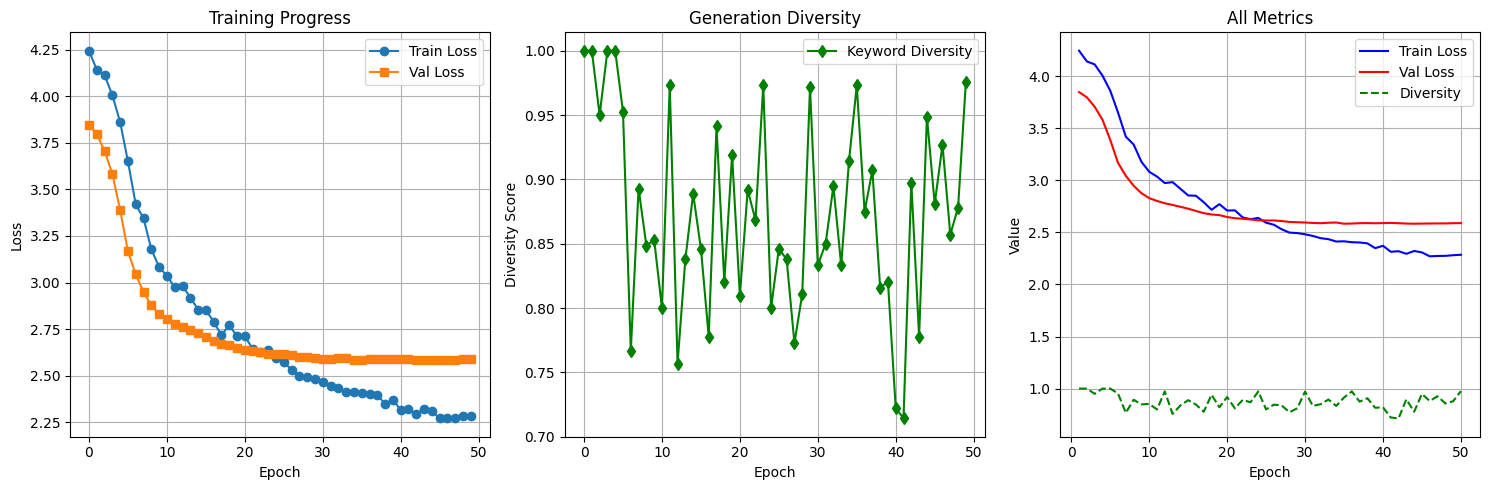


✅ LoRA Training complete!

🧪 Testing the LoRA trained model...
Loading LoRA model from /content/drive/MyDrive/pinterest-flan-t5-lora-best...
✅ LoRA model loaded successfully!

📌 James Bond (Spy)

Variation 1:
Keywords: late 20th century british spy uniforms, black-and-white photography, noir crime scenes, Bond aesthetics
Visual Score: 0.50
Pinterest Score: 0.25

📌 Queen Elizabeth II (Queen)

Variation 1:
Keywords: queen elizabeth II statuette, golden crown, 20th century elegance, british monarchy aesthetic, vintage gowns, black and white art, royal hairstyles
Visual Score: 0.43
Pinterest Score: 0.43

📌 Florence Nightingale (Nurse)

Variation 1:
Keywords: 19th century nursing gowns, london art gallery aesthetic, Victorian nurses, vintage dresses, black and white art, stained glass windows, English countryside
Visual Score: 0.43
Pinterest Score: 0.29

🎉 LoRA Pipeline complete! Your model is ready for Pinterest keyword generation.


In [ ]:
def main():
    """Main execution function"""

    set_seed(Config.SEED)
    mount_drive()

    trainer = PinterestLoRATrainer(Config)

    train_data, val_data = trainer.prepare_data(Config.DATASET_PATH)

    history = trainer.train(train_data, val_data)
    print("\n✅ LoRA Training complete!")

    print("\n🧪 Testing the LoRA trained model...")

    generator = PinterestLoRAGenerator(f"{Config.MODEL_SAVE_PATH}-best")

    test_cases = [
        {
            "personality_name": "James Bond",
            "role": "Spy",
            "culture_region": "Britain",
            "time_period": "Late 20th century"
        },
        {
            "personality_name": "Queen Elizabeth II",
            "role": "Queen",
            "culture_region": "Britain",
            "time_period": "20th-21st Century"
        },
        {
            "personality_name": "Florence Nightingale",
            "role": "Nurse",
            "culture_region": "English",
            "time_period": "19th Century"
        }
    ]

    for test_case in test_cases:
        result = generator.generate(**test_case)

        print(f"\n📌 {result['personality']} ({result['role']})")
        for i, variation in enumerate(result['variations'], 1):
            print(f"\nVariation {i}:")
            print(f"Keywords: {variation['keywords']}")
            print(f"Visual Score: {variation['quality']['visual_score']:.2f}")
            print(f"Pinterest Score: {variation['quality']['pinterest_score']:.2f}")

    print("\n🎉 LoRA Pipeline complete! Your model is ready for Pinterest keyword generation.")

if __name__ == "__main__":
    main()

# 10. Some Additional Test Cases

In [ ]:

generator = PinterestLoRAGenerator(f"{Config.MODEL_SAVE_PATH}-best")

test_cases = [
      {
          "personality_name": "Cleopatra",
          "role": "Royalty",
          "culture_region": "Egyptian",
          "time_period": "Ancient Egypt",
          "bio": "Cleopatra VII was the last active ruler of the Ptolemaic Kingdom of Egypt. Known for her political acumen, charm, and alliances with Julius Caesar and Mark Antony, she played a key role in Roman civil wars. Her reign marked the end of Hellenistic Egypt and the beginning of Roman dominance."
      },
      {
          "personality_name": "Leonardo da Vinci",
          "role": "Polymath",
          "culture_region": "Italian",
          "time_period": "Renaissance",
          "bio": "Leonardo da Vinci was an Italian polymath of the Renaissance era, celebrated for his contributions to art, science, engineering, and anatomy. His most famous works include *The Last Supper* and *Mona Lisa*. He is widely regarded as one of the greatest creative geniuses in history."
      },
      {
          "personality_name": "Malcolm X",
          "role": "Activist",
          "culture_region": "American",
          "time_period": "20th Century",
          "bio": "Malcolm X was an American civil rights leader and minister known for his advocacy for Black empowerment and the Nation of Islam. He challenged systemic racism and promoted Black pride and self-determination, becoming an iconic figure in the struggle for racial justice."
      },
      {
          "personality_name": "Ada Lovelace",
          "role": "Mathematician",
          "culture_region": "British",
          "time_period": "19th Century",
          "bio": "Ada Lovelace was an English mathematician and writer known for her work on Charles Babbage's Analytical Engine. She is widely regarded as the world's first computer programmer due to her foresight in seeing the machine's potential beyond pure calculation."
      },
      {
          "personality_name": "Mansa Musa",
          "role": "Royalty",
          "culture_region": "Mali Empire (West African)",
          "time_period": "14th Century",
          "bio": "Mansa Musa was the ruler of the Mali Empire in the 14th century and is considered one of the richest individuals in history. His famous pilgrimage to Mecca showcased his immense wealth and helped establish Mali as a powerful cultural and economic center."
      },
      {
          "personality_name": "Frida Kahlo",
          "role": "Artist",
          "culture_region": "Mexican",
          "time_period": "20th Century",
          "bio": "Frida Kahlo was a Mexican painter known for her bold self-portraits and works inspired by nature, identity, and Mexican popular culture. Despite enduring lifelong health issues, she became an iconic figure in art, feminism, and political activism."
      },
      {
          "personality_name": "Genghis Khan",
          "role": "Conqueror",
          "culture_region": "Mongolian",
          "time_period": "13th Century",
          "bio": "Genghis Khan was the founder of the Mongol Empire, which became the largest contiguous empire in history. He united nomadic tribes and led military campaigns across Asia and Europe, leaving a profound impact on global history, trade, and culture."
      }
    ]



for test_case in test_cases:
    result = generator.generate(**test_case)

    print(f"\n📌 {result['personality']} ({result['role']})")
    for i, variation in enumerate(result['variations'], 1):
        print(f"\nVariation {i}:")
        print(f"Keywords: {variation['keywords']}")
        print(f"Visual Score: {variation['quality']['visual_score']:.2f}")
        print(f"Pinterest Score: {variation['quality']['pinterest_score']:.2f}")

print("\n🎉 Pipeline complete! Your model is ready for Pinterest keyword generation.")




🧪 Testing the trained model...
Loading LoRA model from /content/drive/MyDrive/pinterest-flan-t5-lora-best...
✅ LoRA model loaded successfully!

📌 Cleopatra (Royalty)

Variation 1:
Keywords: roman throne, Ptolemaic monarchy, Roman empire aesthetics, golden crown, ancient egyptian splendor, king of Egypt
Visual Score: 0.17
Pinterest Score: 0.17

📌 Leonardo da Vinci (Polymath)

Variation 1:
Keywords: last supper, renaissance art, marble statues, Mona Lisa aesthetic, Renaissance architecture, The Last Supper
Visual Score: 0.33
Pinterest Score: 0.17

📌 Malcolm X (Activist)

Variation 1:
Keywords: black empowerment posters, racial justice protests, nation of Islam aesthetic, anti-racism activism, white supremacy, black pride, civil rights struggle
Visual Score: 0.14
Pinterest Score: 0.14

📌 Ada Lovelace (Mathematician)

Variation 1:
Keywords: charles babbage's analytic engine aesthetic, mathematician elegance, computer science aesthetics, britain and england aesthetic
Visual Score: 0.75
Pin